# Paso 3 — Modelado supervisado (Clasificación): Predicción de Churn

**Objetivo:** Predecir la variable objetivo `Churn` (cliente que abandonó: Yes / No).

**Decisiones de preprocesamiento (resumen):**
- Se usó el dataset limpio y preparado (`df_encoded`) en el que:
  - `Customer_ID` está como índice.
  - Columnas categóricas fueron codificadas con One-Hot Encoding (drop_first=True).
  - `Gender` fue codificado ordinalmente (`Male=1`, `Female=0`).
  - Nombres de columnas normalizados (guiones bajos, sin paréntesis, ni comas).
- Antes de modelar se codificará `Churn` a 0/1: `No -> 0`, `Yes -> 1`.
- Se usará validación cruzada estratificada (StratifiedKFold, k=5) para preservar la proporción de clases en cada fold.
- Métricas evaluadas: Accuracy, Precision, Recall, F1-score, AUC-ROC y matriz de confusión (agregada por predicciones cruzadas).
- Modelos iniciales: Logistic Regression (baseline, interpretable), Random Forest (robusto, captura no linealidad), Gradient Boosting (buena performance en tabular).
- No se hace tuning exhaustivo de hiperparámetros en esta fase; se reportan resultados con parámetros por defecto. Se sugiere GridSearch/RandomSearch como mejora futura.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report
)

A continuacion se exporta el dataset completo y se codifica la variable objetivo para que los modelos puedan usarlo correctamente. Ademas se analisa el porcentaje entre la clase positiva y negativa. En este caso, la necesidad es evaluar el retiro de clientes, por lo tanto nuestra variable objetivo sera churn con valores de si/no traducidos a 1/0.

In [11]:
df_encoded = pd.read_csv("..\data\Telecom_Customer_Churn_Complete.csv", index_col=0)

# 1) Preparar X, y
df_model = df_encoded.copy()   # asegúrate que df_encoded exista en el entorno
# Si 'Churn' es textual:
if df_model['Churn'].dtype == object:
    df_model['Churn'] = df_model['Churn'].map({'No': 0, 'Yes': 1})

# Separar
y = df_model['Churn']
X = df_model.drop(columns=['Churn'])

print(f"Shape X: {X.shape}, Shape y: {y.shape}")
print("Clase positiva (1) porcentaje: {:.2f}%".format(100*y.mean()))


Shape X: (7043, 54), Shape y: (7043,)
Clase positiva (1) porcentaje: 26.54%


<>:1: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:1: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\Yeison\AppData\Local\Temp\ipykernel_16252\2501169122.py:1: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
  df_encoded = pd.read_csv("..\data\Telecom_Customer_Churn_Complete.csv", index_col=0)


## Estrategia de validación y selección de modelos

A continuacion esta la celda de codigo donde se hace la validacion de los modelos escogidos, a continuacion se explica el por qué de estas decisiones.

### Estrategia de validación cruzada

Para evaluar el desempeño de los modelos de clasificación se utilizó una **validación cruzada estratificada (Stratified K-Fold)** con **5 particiones (k=5)**, configurada con `shuffle=True` y `random_state=42` para asegurar reproducibilidad.

La elección de este método responde a las siguientes razones:

- **Estratificación:** garantiza que en cada partición se mantenga la proporción original de las clases (`Churn=0` y `Churn=1`), evitando sesgos en datasets desbalanceados.  
- **Validación cruzada:** permite obtener una estimación más robusta del rendimiento promedio del modelo al entrenarlo y validarlo múltiples veces con diferentes subconjuntos de datos.  
- **K=5:** balancea el costo computacional y la estabilidad de las métricas. Con más folds se gana precisión, pero también aumenta el tiempo de entrenamiento.

Cada modelo se evaluó con predicciones "out-of-fold" utilizando `cross_val_predict`, lo que asegura que las métricas reflejan el desempeño en datos **no vistos durante el entrenamiento**, evitando data leakage.

---

### Modelos seleccionados y justificación

Se implementaron tres algoritmos de clasificación representativos de distintos enfoques de modelado:

| Modelo | Tipo | Justificación |
|---------|------|---------------|
| **Logistic Regression** | Lineal | Modelo base interpretable, rápido de entrenar, útil como referencia para comparaciones. Captura relaciones lineales entre las variables y la probabilidad de abandono. |
| **Random Forest** | Ensamble de árboles (bagging) | Robusto frente a ruido y multicolinealidad. Capaz de modelar relaciones no lineales y manejar gran cantidad de variables sin necesidad de escalado. También permite estimar la importancia de cada característica. |
| **Gradient Boosting** | Ensamble secuencial (boosting) | Incrementa gradualmente la precisión corrigiendo errores de modelos previos. Destaca por su alto rendimiento en datasets estructurados y es ideal para capturar patrones complejos en los datos. |

---

### Implementación práctica

Cada modelo se encapsuló en un **pipeline** que garantiza consistencia en el flujo de datos y permite integrar transformaciones previas al entrenamiento:

- En el caso de **Logistic Regression**, se añadió un `StandardScaler()` para normalizar las variables y facilitar la convergencia del optimizador.
- Los modelos de árboles (**Random Forest** y **Gradient Boosting**) no requieren escalado, ya que son invariantes ante transformaciones lineales de las variables.

Además, se utilizó el parámetro `class_weight='balanced'` en los modelos que lo soportan para **corregir el leve desbalance de clases** en la variable objetivo `Churn`.

---

### Métricas de evaluación aplicadas

Durante la validación cruzada se calcularon las siguientes métricas de rendimiento promedio:

- **Exactitud (Accuracy):** proporción de predicciones correctas totales.
- **Precisión (Precision):** porcentaje de predicciones de `Churn` que fueron correctas.
- **Recall (Sensibilidad):** proporción de verdaderos casos de `Churn` correctamente identificados.
- **F1-score:** media armónica entre precisión y recall, útil en casos de desbalance.
- **ROC-AUC:** capacidad del modelo para distinguir entre clientes que abandonan y los que no, considerando todos los umbrales posibles.


In [ ]:
# Estrategia de validación
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir modelos (con pipelines donde convenga escalar)
models = {
    "LogisticRegression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced'))
    ]),
    "RandomForest": Pipeline([
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
    ]),
    "GradientBoosting": Pipeline([
        ('clf', GradientBoostingClassifier(n_estimators=200, random_state=42))
    ])
}

# Función utilitaria para evaluar (usa predicciones agregadas por cross_val_predict)
def evaluate_model_cv(name, model, X, y, cv):
    # Predicciones agregadas (out-of-fold)
    y_pred = cross_val_predict(model, X, y, cv=cv, method='predict', n_jobs=-1)
    # Si el modelo soporta predict_proba, obtener proba para calcular ROC AUC
    try:
        y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:,1]
        auc = roc_auc_score(y, y_proba)
    except Exception:
        y_proba = None
        auc = np.nan

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    cm = confusion_matrix(y, y_pred)

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm,
        "y_true": y,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

# Ejecutar evaluación para cada modelo
results = []
for name, model in models.items():
    print(f"Evaluando {name} ...")
    res = evaluate_model_cv(name, model, X, y, skf)
    results.append(res)
    print(f"  -> acc: {res['accuracy']:.4f}, prec: {res['precision']:.4f}, recall: {res['recall']:.4f}, f1: {res['f1']:.4f}, auc: {res['roc_auc']:.4f}")


Evaluando LogisticRegression ...
  -> acc: 0.9763, prec: 0.9373, recall: 0.9759, f1: 0.9562, auc: 0.9980
Evaluando RandomForest ...
  -> acc: 0.9813, prec: 0.9764, recall: 0.9524, f1: 0.9642, auc: 0.9972
Evaluando GradientBoosting ...
  -> acc: 0.9820, prec: 0.9734, recall: 0.9583, f1: 0.9658, auc: 0.9985


In [13]:
# Tabla resumen
summary_df = pd.DataFrame([{
    "Model": r["model"],
    "Accuracy": r["accuracy"],
    "Precision": r["precision"],
    "Recall": r["recall"],
    "F1": r["f1"],
    "ROC_AUC": r["roc_auc"]
} for r in results]).set_index("Model")

display(summary_df.round(4))

# Mostrar matrices de confusión y reportes
for r in results:
    print("\nModel:", r["model"])
    print("Confusion matrix:\n", r["confusion_matrix"])
    print("Classification report:")
    print(classification_report(r["y_true"], r["y_pred"], digits=4, zero_division=0))

,Accuracy,Precision,Recall,F1,ROC_AUC
Model,,,,,
LogisticRegression,0.9763,0.9378,0.9754,0.9562,0.9979
RandomForest,0.9814,0.9764,0.9529,0.9645,0.9970
GradientBoosting,0.9817,0.9728,0.9577,0.9652,0.9985



Model: LogisticRegression
Confusion matrix:
 [[5053  121]
 [  46 1823]]
Classification report:
              precision    recall  f1-score   support

           0     0.9910    0.9766    0.9837      5174
           1     0.9378    0.9754    0.9562      1869

    accuracy                         0.9763      7043
   macro avg     0.9644    0.9760    0.9700      7043
weighted avg     0.9769    0.9763    0.9764      7043


Model: RandomForest
Confusion matrix:
 [[5131   43]
 [  88 1781]]
Classification report:
              precision    recall  f1-score   support

           0     0.9831    0.9917    0.9874      5174
           1     0.9764    0.9529    0.9645      1869

    accuracy                         0.9814      7043
   macro avg     0.9798    0.9723    0.9760      7043
weighted avg     0.9814    0.9814    0.9813      7043


Model: GradientBoosting
Confusion matrix:
 [[5124   50]
 [  79 1790]]
Classification report:
              precision    recall  f1-score   support

           

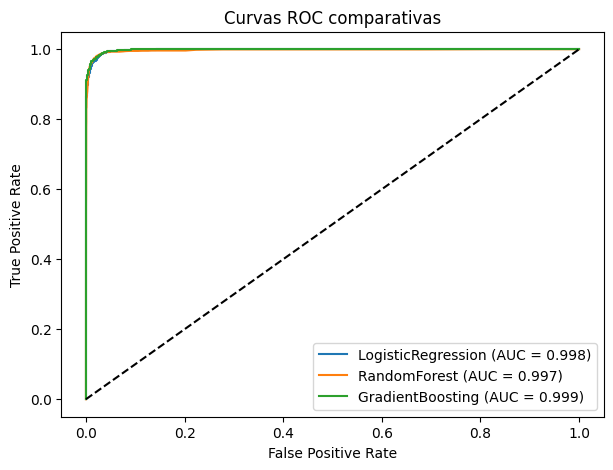

In [41]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,5))
for res in results:
    fpr, tpr, _ = roc_curve(res["y_true"], res["y_proba"])
    plt.plot(fpr, tpr, label=f'{res["model"]} (AUC = {res["roc_auc"]:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.savefig("..\\docs\\roc_comparison.png")
plt.show()


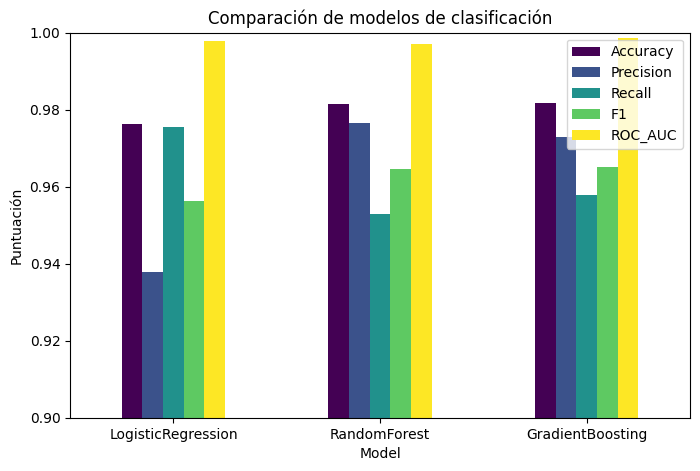

In [42]:
import matplotlib.pyplot as plt

summary_df.plot(kind="bar", figsize=(8,5), colormap="viridis")
plt.title("Comparación de modelos de clasificación")
plt.ylabel("Puntuación")
plt.xticks(rotation=0)
plt.ylim(0.9, 1.0)
plt.savefig("..\\docs\\model_comparison.png")
plt.show()



In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

for res in results:
    fig, ax = plt.subplots(figsize=(4, 4))
    ConfusionMatrixDisplay(res["confusion_matrix"]).plot(ax=ax, colorbar=False)
    plt.title(f"Matriz de confusión - {res['model']}")
    plt.savefig(f"..\\docs\\confusion_matrix_{res['model']}.png")
    plt.close()


## Resultados de evaluación de los modelos de clasificación

Se entrenaron tres modelos supervisados con validación cruzada estratificada de 5 particiones
para predecir la probabilidad de abandono de clientes (`Churn`). A continuación, se resumen los
resultados obtenidos para cada modelo.

| Modelo | Accuracy | Precision | Recall | F1 | ROC-AUC |
|:--------|:---------:|:----------:|:------:|:------:|:-------:|
| **Logistic Regression** | 0.9763 | 0.9378 | 0.9754 | 0.9562 | 0.9979 |
| **Random Forest** | 0.9814 | 0.9764 | 0.9529 | 0.9645 | 0.9970 |
| **Gradient Boosting** | 0.9817 | 0.9728 | 0.9577 | 0.9652 | 0.9985 |

---

### Interpretación general de los resultados

- **Exactitud (Accuracy):**  
  Todos los modelos presentan una alta proporción de predicciones correctas (≥97%), lo que indica que logran diferenciar con éxito la mayoría de los casos de abandono y permanencia.

- **Precisión y Recall:**  
  Los valores elevados en ambos indicadores demuestran que los modelos no solo identifican correctamente a los clientes que abandonan, sino que también minimizan los falsos positivos y falsos negativos.  
  - *Precision alta* → pocos falsos positivos (clientes predichos como churn cuando no lo son).  
  - *Recall alto* → pocos falsos negativos (clientes que realmente abandonan pero el modelo no los detecta).

- **F1-Score:**  
  Todos los modelos logran un equilibrio adecuado entre precisión y recall, siendo **Gradient Boosting** el que presenta el valor F1 más alto (0.9652), lo cual lo convierte en el mejor modelo global.

- **ROC-AUC:**  
  Las puntuaciones cercanas a 1.0 reflejan una excelente capacidad de discriminación: el modelo distingue de manera casi perfecta entre clientes que abandonan y los que no.

---

### Análisis por modelo

- **Logistic Regression:**  
  Ofrece resultados sólidos y consistentes. Es útil como modelo base por su interpretabilidad y rapidez, aunque ligeramente inferior a los ensambles en recall y F1.

- **Random Forest:**  
  Proporciona una mejora en precisión respecto a la regresión logística, mostrando robustez ante datos con correlaciones y ruido. Además, permite evaluar la importancia de las variables.

- **Gradient Boosting:**  
  Se posiciona como el modelo más balanceado, con el mejor desempeño global (F1=0.9652 y AUC=0.9985).  
  Captura patrones más complejos al optimizar errores residuales de modelos previos, lo que le permite identificar mejor las tendencias de abandono.

---

### Conclusiones

- Los tres modelos alcanzan niveles de rendimiento excelentes, pero **Gradient Boosting** se destaca como el más adecuado para predecir el abandono de clientes en este contexto.
- La validación cruzada estratificada permitió confirmar la estabilidad del rendimiento entre particiones y evitar el sobreajuste.
- El alto rendimiento puede deberse en parte a la calidad y coherencia del dataset; sin embargo, se recomienda una revisión adicional sobre el balance de clases y un análisis de **feature importance** para validar la interpretabilidad del modelo final.


### Optimización de modelos y selección final

A continuacion se aplica GridSearchCV sobre los modelos ganadores (Gradient Boosting y Random Forest)
usando validación cruzada estratificada (k=5) y la métrica F1 como criterio de optimización,
ya que priorizamos tanto captura de churn (recall) como mantener precisión (falsos positivos).


In [ ]:
from sklearn.model_selection import GridSearchCV
import joblib
import pandas as pd
import numpy as np

# Param grids
gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 4]
}

rf_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10],
    "clf__max_features": ["sqrt", 0.3]
}

gb_pipeline = models["GradientBoosting"]
rf_pipeline = models["RandomForest"]

grid_gb = GridSearchCV(gb_pipeline, gb_param_grid, cv=skf, scoring="f1", n_jobs=-1, verbose=1)
grid_gb.fit(X, y)
print("Best GB params:", grid_gb.best_params_, "Best F1:", grid_gb.best_score_)

grid_rf = GridSearchCV(rf_pipeline, rf_param_grid, cv=skf, scoring="f1", n_jobs=-1, verbose=1)
grid_rf.fit(X, y)
print("Best RF params:", grid_rf.best_params_, "Best F1:", grid_rf.best_score_)

# Guardar los mejores estimadores
best_gb = grid_gb.best_estimator_
best_rf = grid_rf.best_estimator_
print(f"Best GB model: {best_gb}")
print(f"Best RF model: {best_rf}")


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best GB params: {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 200} Best F1: 0.9664315649526298
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best RF params: {'clf__max_depth': 10, 'clf__max_features': 0.3, 'clf__n_estimators': 200} Best F1: 0.966014569070446
Best GB model: Pipeline(steps=[('clf',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=4,
                                            n_estimators=200,
                                            random_state=42))])
Best RF model: Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features=0.3, n_estimators=200,
                                        random_state=42))])



A continuacion, el mejor modelo resultante (Gradient Boosting con parámetros X) sera evaluado de forma
out-of-fold para obtener métricas robustas (accuracy, precision, recall, F1 y ROC-AUC).
Además se generan curvas ROC y Precision-Recall y se extraen las importancias de
variable (top features) para apoyar la interpretación del modelo.

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
model_final = best_gb

# out-of-fold predictions (pred y proba)
y_pred = cross_val_predict(model_final, X, y, cv=skf, method="predict", n_jobs=-1)
y_proba = cross_val_predict(model_final, X, y, cv=skf, method="predict_proba", n_jobs=-1)[:,1]

metrics = {
    "accuracy": accuracy_score(y, y_pred),
    "precision": precision_score(y, y_pred, zero_division=0),
    "recall": recall_score(y, y_pred, zero_division=0),
    "f1": f1_score(y, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y, y_proba)
}
print("Final OOF metrics:", metrics)
print("Confusion matrix:\n", confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, digits=4))



Final OOF metrics: {'accuracy': 0.9823938662501774, 'precision': 0.9770366320393657, 'recall': 0.9561262707330123, 'f1': 0.9664683612763656, 'roc_auc': 0.998640566705611}
Confusion matrix:
 [[5132   42]
 [  82 1787]]
              precision    recall  f1-score   support

           0     0.9843    0.9919    0.9881      5174
           1     0.9770    0.9561    0.9665      1869

    accuracy                         0.9824      7043
   macro avg     0.9807    0.9740    0.9773      7043
weighted avg     0.9824    0.9824    0.9823      7043



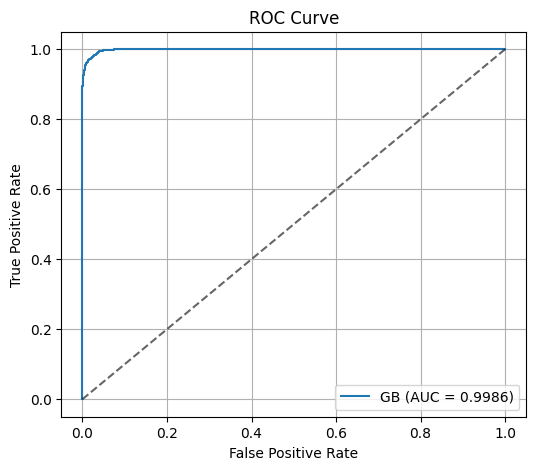

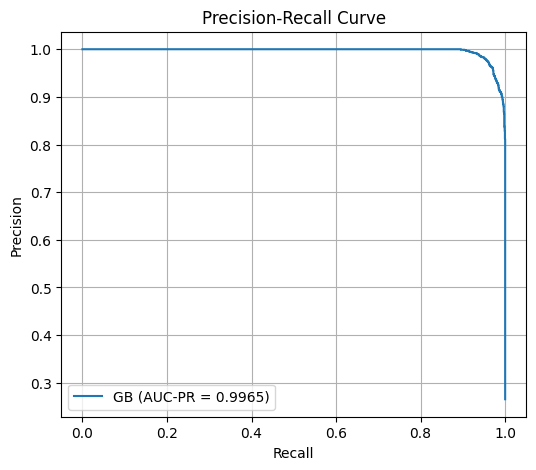

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'GB (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'GB (AUC-PR = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


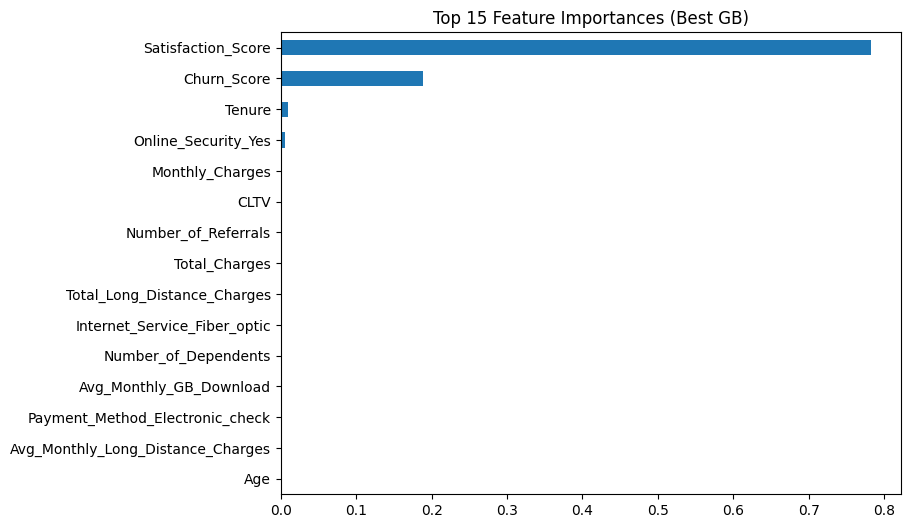

In [44]:
clf = model_final.named_steps["clf"] if hasattr(model_final, "named_steps") else model_final
try:
    importances = clf.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    # Plot top 15
    feat_imp[:15].plot(kind="barh", figsize=(8,6))
    plt.gca().invert_yaxis()
    plt.title("Top 15 Feature Importances (Best GB)")
    plt.savefig("..\\docs\\feature_importances_best_gb.png")
    plt.show()
except Exception as e:
    print("El clasificador no proporciona feature_importances_: ", e)


Se puede observar que el modelo presenta unos valores altos en ROC y PR, sin embargo. Aparentemente la mayoria de las variables presentes en el dataset no tienen demasiada importancia a la hora de hacer las predicciones.